# Test processing

## Test pre-processing

In [2]:
import os
import importlib
import collections
import numpy as np
import nibabel as nib
import tensorflow as tf

from tqdm import tqdm

from utils import plot_utils
from datasets import get_dataset
from utils.med_utils import data_io, pre_processing, resampling, visualize

def show_memory(msg = ''):
    print('{}{}'.format(msg if not msg else msg + '\t: ', {
        k : '{:.3f}'.format(v / 1024 ** 3) for k, v in tf.config.experimental.get_memory_info('GPU:0').items()
    }))
    tf.config.experimental.reset_memory_stats('GPU:0')

/etinfo/users2/qlanglois/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-04-07 08:40:36.754856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 08:40:36.851117: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-07 08:40:36.875145: E tensorflow/stream_executor/cuda/cuda_blas.cc

In [3]:
ds = get_dataset('total_segmentator')

Loading dataset total_segmentator...


2023-04-07 08:40:47.795987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 08:40:48.531030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14783 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-04-07 08:40:48.531887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14485 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


Image shape : (249, 188, 213) - mask shape : (249, 188, 213, 104)


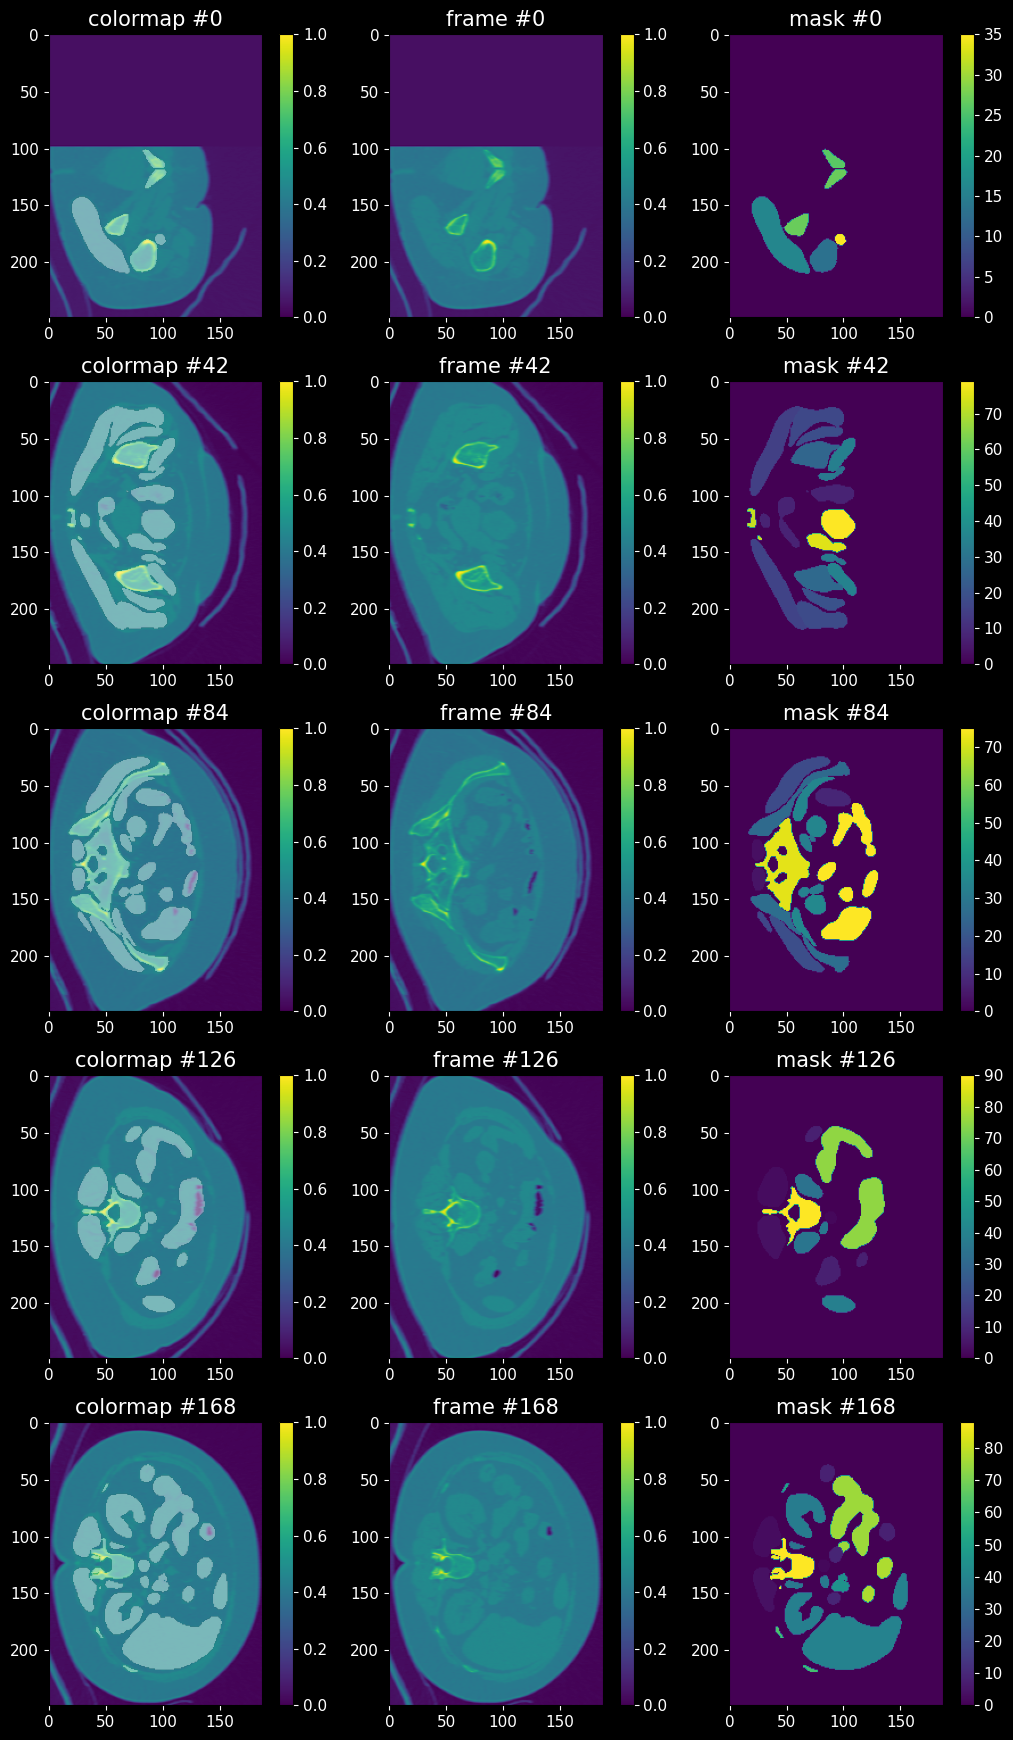

In [4]:
importlib.reload(data_io)
importlib.reload(pre_processing)
importlib.reload(visualize)

idx      = 0
orig_image, orig_voxel_dims = data_io.load_medical_image(ds.loc[idx, 'images'])
orig_mask, _  = data_io.load_medical_seg(ds.loc[idx, 'segmentation'])

print('Image shape : {} - mask shape : {}'.format(orig_image.shape, orig_mask.shape))

visualize.plot_mask(orig_image, orig_mask, n = 5)

### Resampling

Image shape : (746, 564, 212) - mask shape : (746, 564, 212)


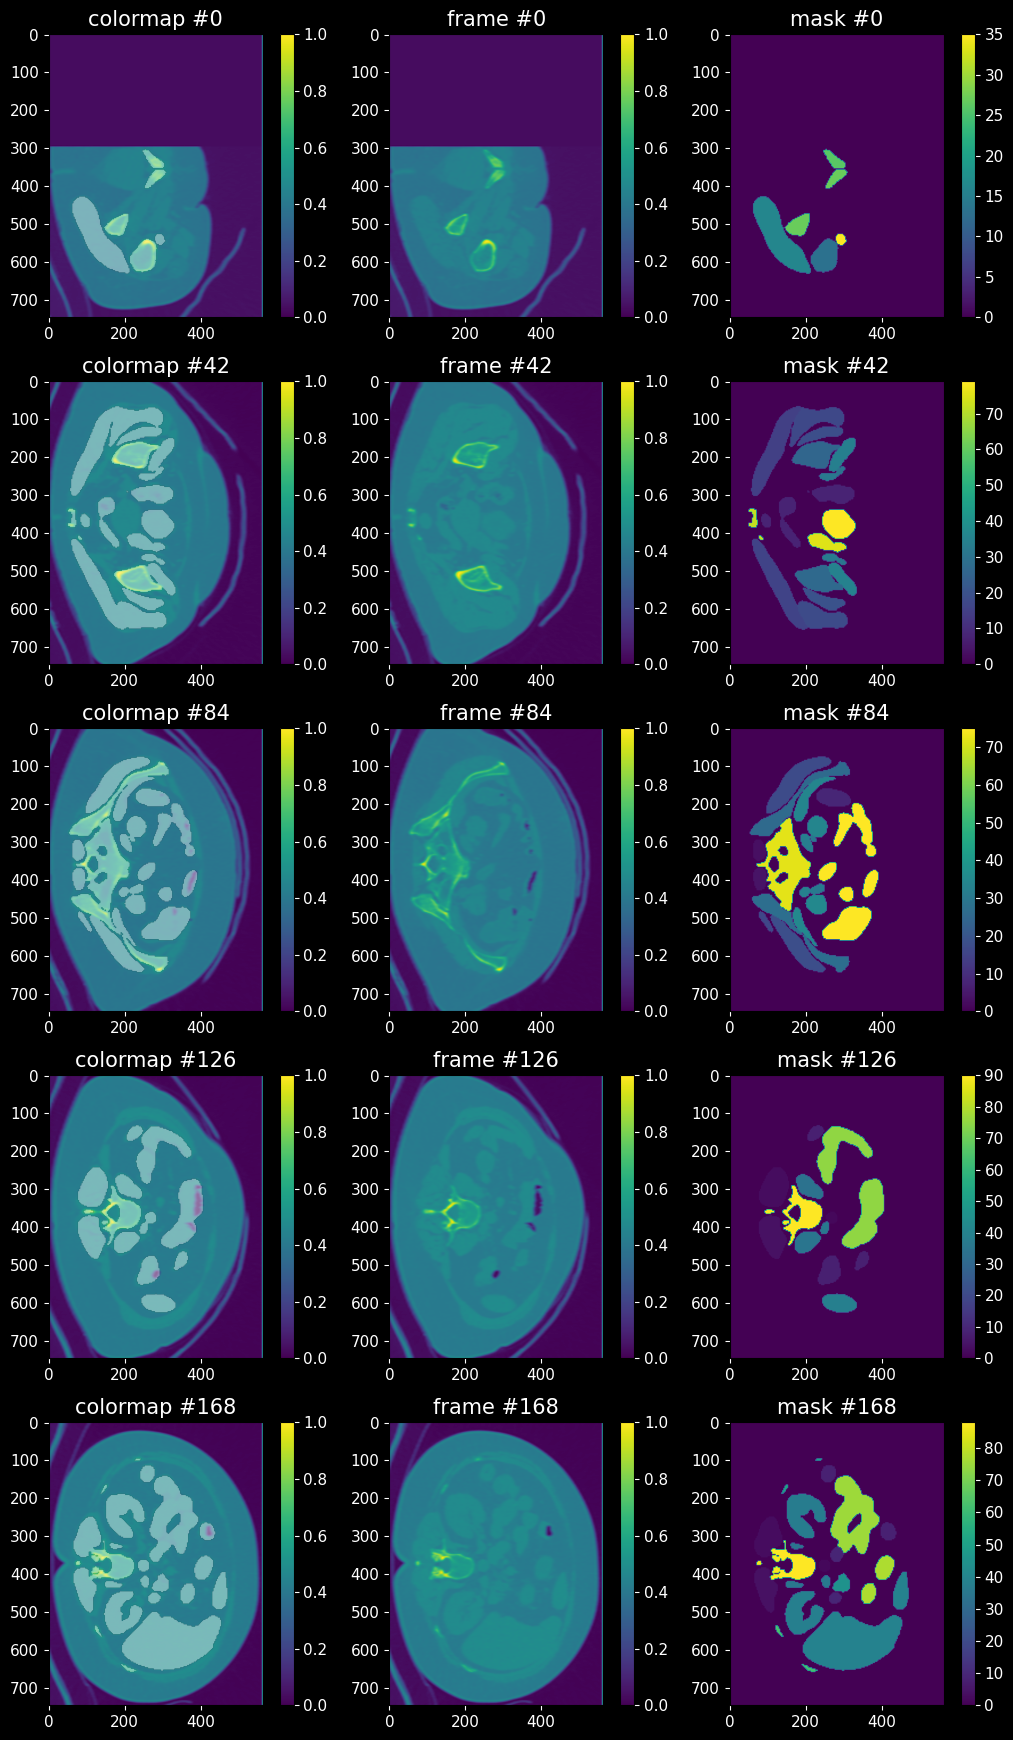

In [5]:
importlib.reload(pre_processing)
importlib.reload(visualize)
importlib.reload(data_io)

voxel_dims = (0.5, 0.5, 1.5)

resized_image, _ = data_io.load_medical_image(
    orig_image, orig_voxel_dims, target_voxel_dims = voxel_dims, interpolation = 'bilinear'
)
resized_mask, _  = data_io.load_medical_seg(
    orig_mask, orig_voxel_dims, target_voxel_dims = voxel_dims, interpolation = 'nearest', remove_label_axe = True
)

print('Image shape : {} - mask shape : {}'.format(resized_image.shape, resized_mask.shape))

visualize.plot_mask(resized_image, resized_mask, n = 5)

### Padding

Image shape : (512, 512, 213) - mask shape : (512, 512, 213, 104)


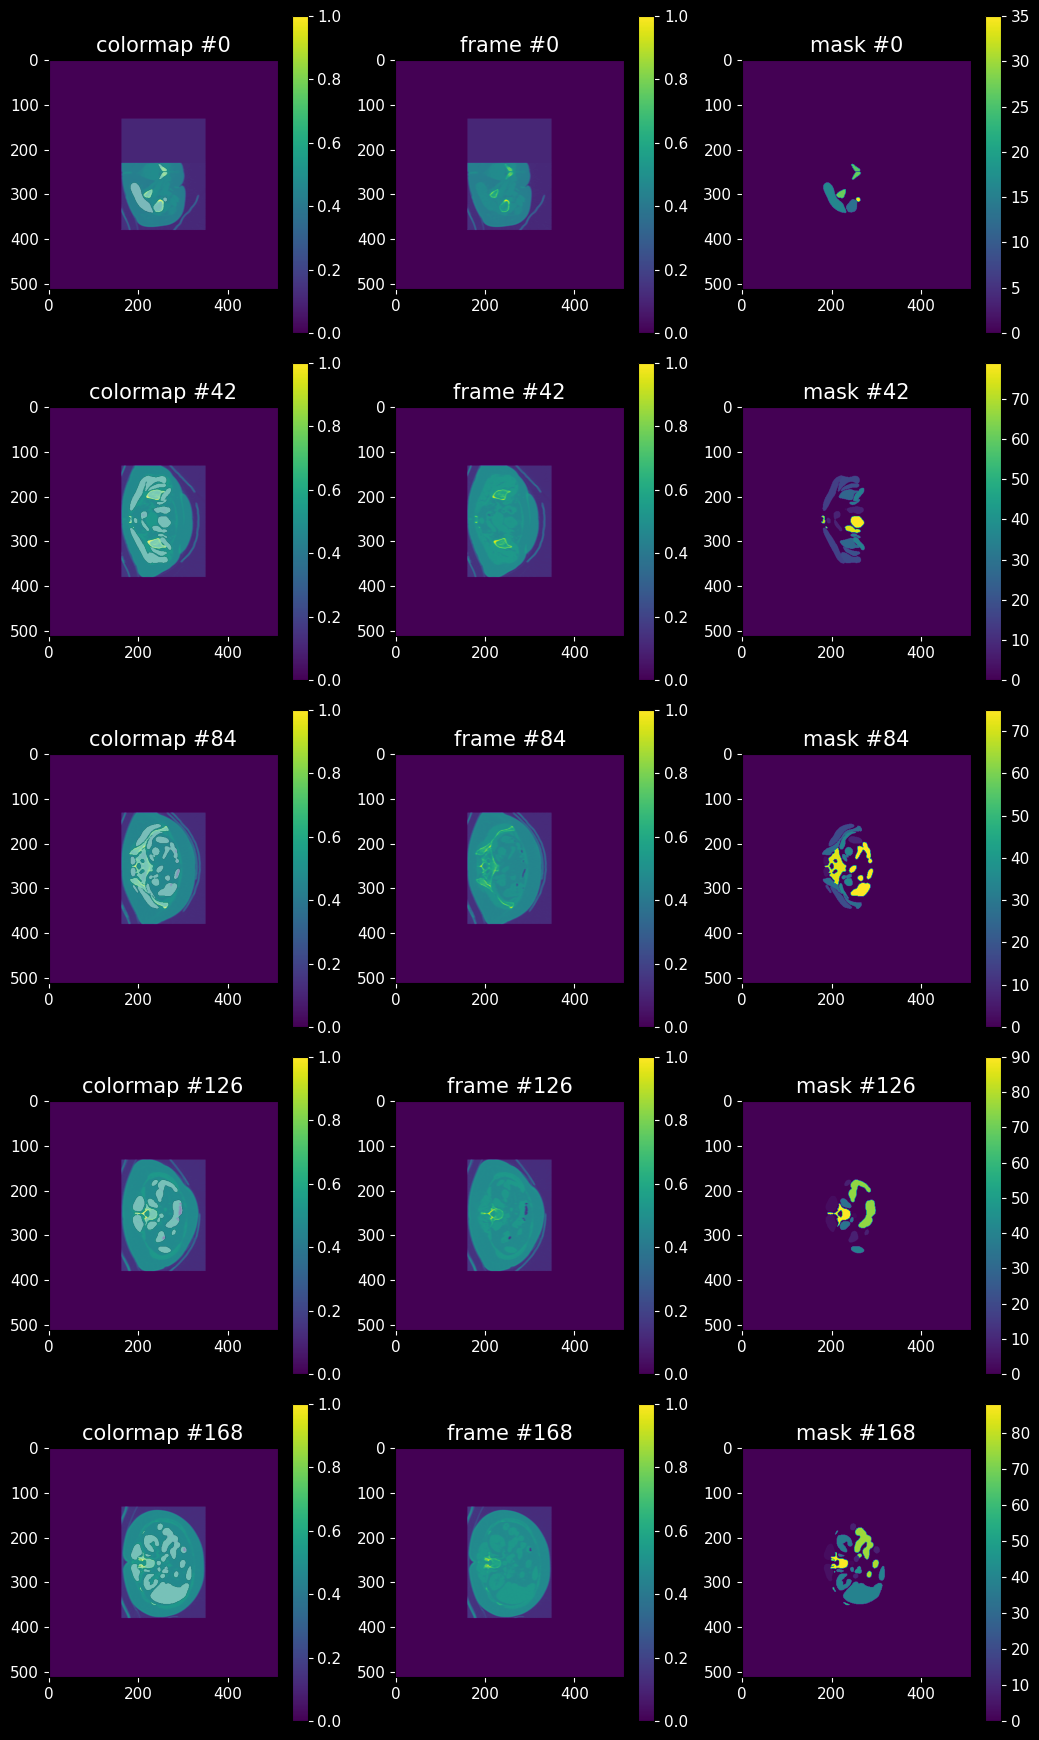

In [8]:
importlib.reload(pre_processing)
importlib.reload(visualize)
importlib.reload(data_io)

target_shape = (512, 512, orig_image.shape[-1])

padded_mask = orig_mask
if not isinstance(padded_mask, tf.sparse.SparseTensor) and len(padded_mask.shape) == 4:
    padded_mask = np.argmax(padded_mask, axis = -1)

padded_image, padded_mask = pre_processing.pad_or_crop(
    orig_image, target_shape, crop_mode = 'random', mask = padded_mask
)

print('Image shape : {} - mask shape : {}'.format(padded_image.shape, padded_mask.shape))

visualize.plot_mask(padded_image, padded_mask, n = 5)

### Cropping

Image shape : (512, 512, 212) - mask shape : (512, 512, 212)


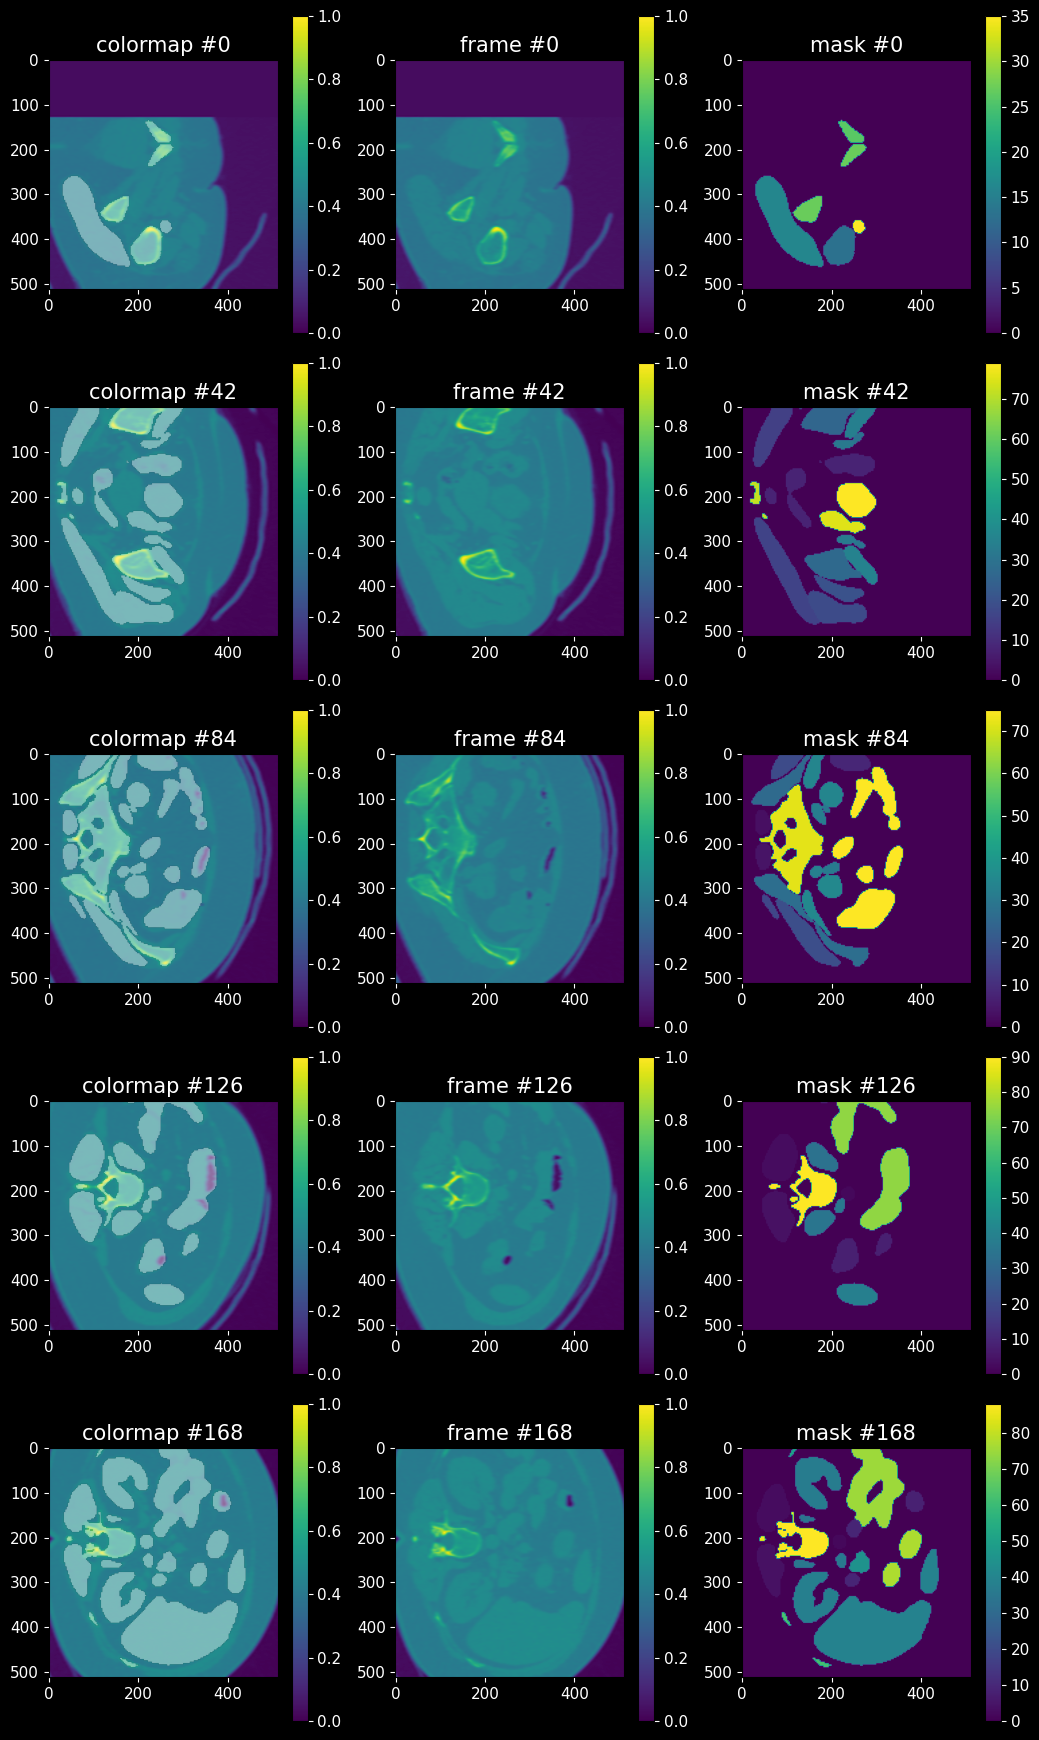

In [9]:
importlib.reload(pre_processing)
importlib.reload(data_io)

target_shape = (512, 512, resized_image.shape[-1])

cropped_image, cropped_mask = pre_processing.pad_or_crop(
    resized_image, target_shape, crop_mode = 'random', mask = resized_mask
)

print('Image shape : {} - mask shape : {}'.format(cropped_image.shape, cropped_mask.shape))

visualize.plot_mask(cropped_image, cropped_mask, n = 5)

## crop then resample

Image shape : (512, 512, 32) - mask shape : (512, 512, 32, 104)


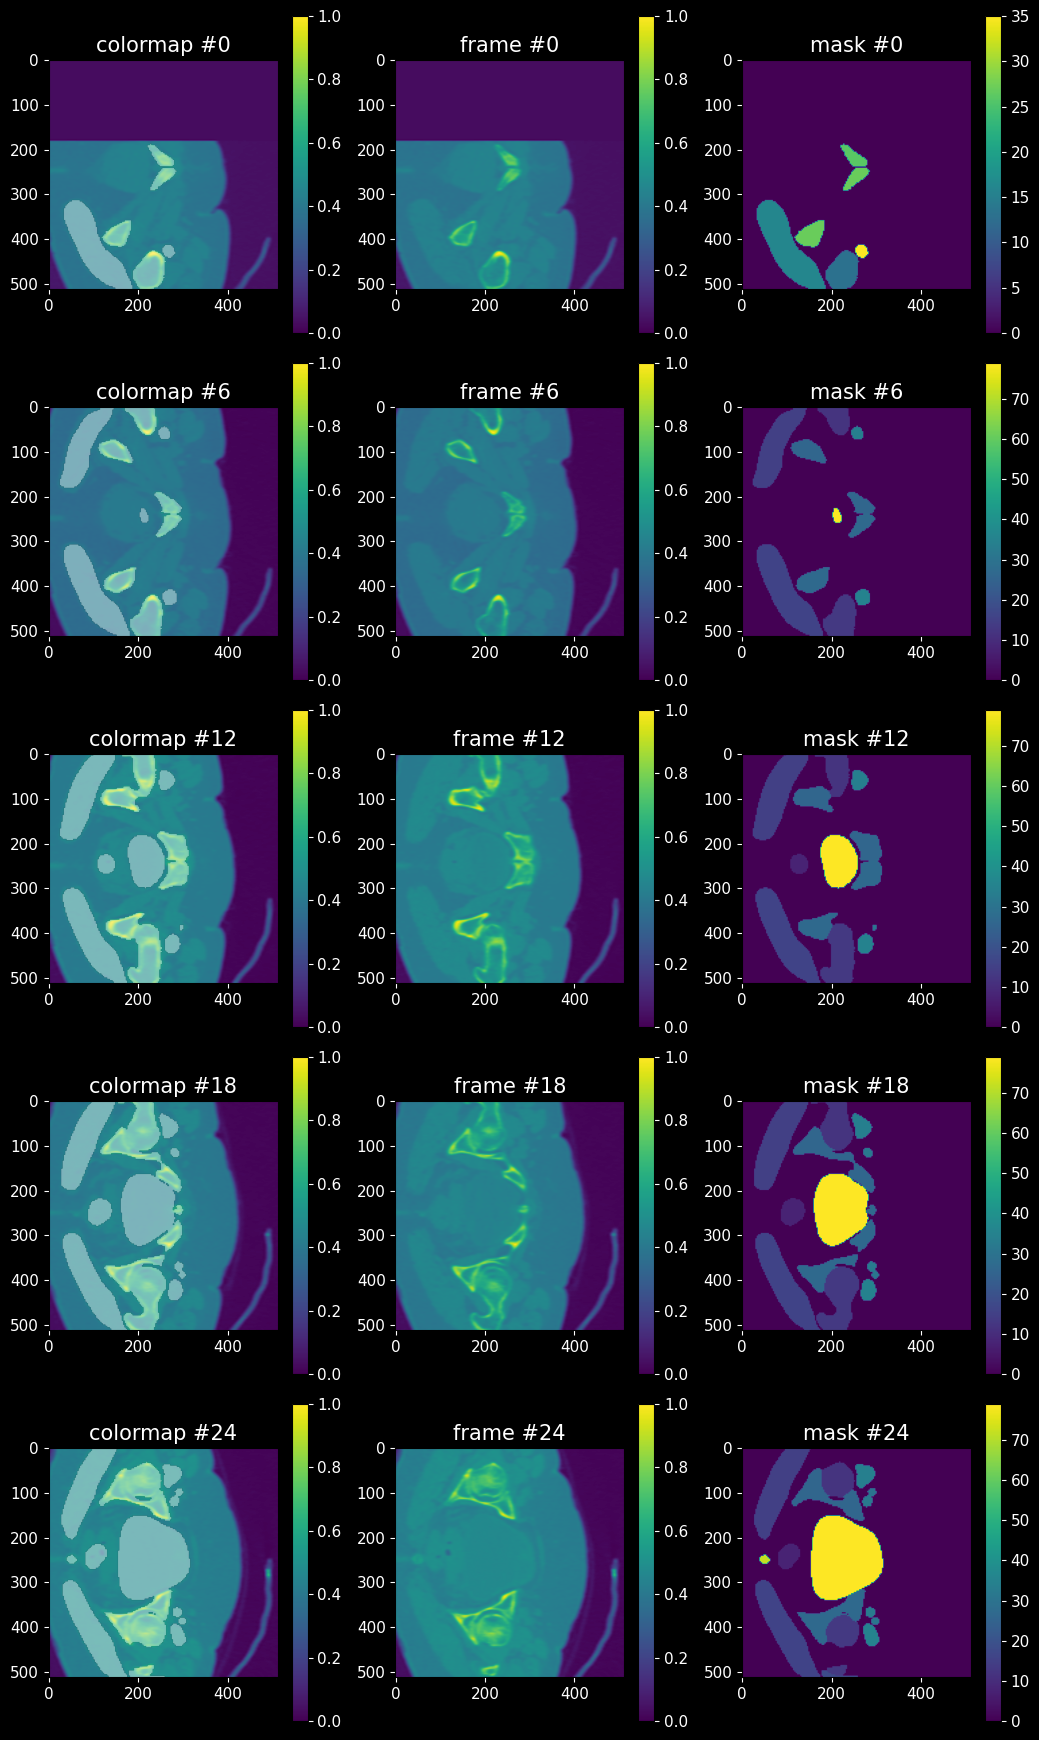

In [10]:
importlib.reload(pre_processing)
importlib.reload(data_io)

target_shape = (512, 512, 32)
target_voxel_dims = (0.5, 0.5, 1.5)

cropped_image, cropped_mask = pre_processing.crop_then_reshape(
    orig_image, orig_voxel_dims, target_shape = target_shape, target_voxel_dims = target_voxel_dims,
    crop_mode = ['center', 'center', 'start'], mask = orig_mask
)

print('Image shape : {} - mask shape : {}'.format(cropped_image.shape, cropped_mask.shape))

visualize.plot_mask(cropped_image, cropped_mask, n = 5)